<a href="https://colab.research.google.com/github/cserock/colab-examples/blob/main/04_TensorFlow_Keras_%EC%98%88%EC%A0%9C(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TensorFlow 설정하기

시작하려면 TensorFlow를 프로그램으로 가져옵니다.

In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


[MNIST 데이터셋](https://www.kaggle.com/datasets/hojjatk/mnist-dataset)을 로드하여 준비합니다. 샘플 값을 정수에서 부동소수로 변환합니다:

참고: 자체 개발 환경을 사용하는 경우에 TensorFlow 2 패키지를 설치하려면 최신 `pip`로 업그레이드했는지 확인합니다. 자세한 내용은 [설치 가이드](https://www.tensorflow.org/install)를 참조합니다.

## 데이터세트 로드하기

[MNIST 데이터세트](https://www.kaggle.com/datasets/hojjatk/mnist-dataset)를 로드하고 준비합니다. 이미지의 픽셀 값 범위는 0~255입니다. 이때 값을 `255.0`으로 나누어 0~1 범위로 조정합니다. 그러면 샘플 데이터를 정수에서 부동 소수점 숫자로 변환합니다.

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# 데이터 확인
print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)

(60000, 28, 28) (10000, 28, 28)
(60000,) (10000,)


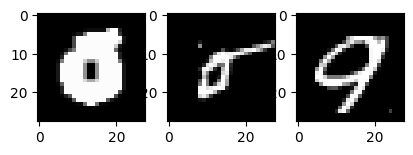

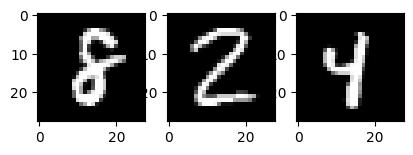

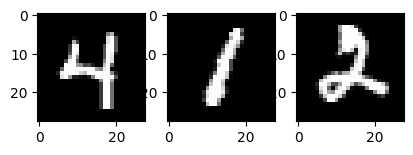

In [4]:
# 이미지 시작화
import matplotlib.pyplot as plt
import random
for i in range(1,4,1):
    for j in range(1,4,1):
        plt.subplot(i,4,j)
        plt.imshow(x_train[random.randint(0,60000)],cmap="gray")
    plt.show()

## 머신 러닝 모델 빌드하기

`tf.keras.Sequential` 모델을 빌드합니다.

In [5]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[`Sequential`](https://www.tensorflow.org/guide/keras/sequential_model)은 각 레이어에 하나의 입력 [텐서](https://www.tensorflow.org/guide/tensor?hl=ko)와 하나의 출력 텐서가 있는 레이어를 쌓는 데 유용합니다. 레이어는 다시 사용할 수 있고 훈련 가능한 변수를 포함하며 일반적인 수학적 구조를 가진 함수입니다. 대부분의 TensorFlow 모델은 레이어로 구성되어 있습니다. 이 모델은 [`Flatten`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten), [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), [`Dropout`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) 레이어를 사용합니다.

각 예시에서 모델은 각 클래스에 대해 하나씩, [logits](https://developers.google.com/machine-learning/glossary#logits) 또는 [log-odds](https://developers.google.com/machine-learning/glossary#log-odds) 스코어 벡터를 반환합니다.

In [6]:
predictions = model(x_train[:1]).numpy()
predictions

array([[0.07059205, 0.08182459, 0.07180769, 0.1730455 , 0.13859357,
        0.09961512, 0.12361126, 0.08675446, 0.05811143, 0.09604431]],
      dtype=float32)

`tf.nn.softmax` 함수는 다음과 같이 이러한 로짓을 각 클래스에 대한 *확률*로 변환합니다.

In [7]:
tf.nn.softmax(predictions).numpy()

array([[0.09704655, 0.09814278, 0.0971646 , 0.10751649, 0.10387542,
        0.09990442, 0.10233072, 0.09862781, 0.09584288, 0.09954832]],
      dtype=float32)

참고: `tf.nn.softmax` 함수를 네트워크의 마지막 레이어에 대한 활성화 함수로 베이킹할 수 있습니다. 이렇게 하면 모델 출력을 더 직접적으로 해석할 수 있지만 이 접근법은 소프트맥스 출력을 사용할 경우 모든 모델에 대해 정확하고 수치적으로 안정적인 손실 계산을 제공하는 것이 불가능하므로 권장하지 않습니다.

`losses.SparseCategoricalCrossentropy`를 사용하여 훈련용 손실 함수를 정의합니다.

In [8]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

손실 함수는 실측 값의 벡터와 로짓의 벡터를 취하고 각 예시에 대한 스칼라 손실을 반환합니다. 이 손실은 참(true) 클래스의 음의 로그 확률과 같습니다. 모델이 올바른 클래스를 확신하는 경우 손실은 0입니다.

이 훈련되지 않은 모델은 무작위에 가까운 확률(각 클래스에 대해 1/10)을 제공하므로 초기 손실은 `-tf.math.log(1/10) ~= 2.3`에 근접해야 합니다.

In [9]:
loss_fn(y_train[:1], predictions).numpy()

np.float32(2.3035412)

훈련을 시작하기 전에 Keras `Model.compile`을 사용하여 모델을 구성하고 컴파일합니다. [`optimizer`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) 클래스를 `adam`으로 설정하고 `loss`를 앞에서 정의한 `loss_fn` 함수로 설정합니다. `metrics` 매개변수를 `accuracy`로 설정하여 모델에 대해 평가할 메트릭을 지정합니다.

In [10]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

## 모델 훈련 및 평가하기

모델을 훈련하고 평가합니다:

In [11]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8601 - loss: 0.4814
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9565 - loss: 0.1453
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9688 - loss: 0.1049
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9729 - loss: 0.0878
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9772 - loss: 0.0711


`Model.evaluate` 메서드는 일반적으로 [검증 세트](https://developers.google.com/machine-learning/glossary#validation-set) 또는 [테스트 세트](https://developers.google.com/machine-learning/glossary#test-set)에서 모델의 성능을 확인합니다.

In [13]:
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 1s - 2ms/step - accuracy: 0.9799 - loss: 0.0699


[0.06988096982240677, 0.9799000024795532]

훈련된 이미지 분류기는 이 데이터셋에서 약 98%의 정확도를 달성합니다. 더 자세한 내용은 [TensorFlow 튜토리얼](https://www.tensorflow.org/tutorials?hl=ko)을 참고하세요.

모델이 확률을 반환하도록 하려면 다음과 같이 훈련된 모델을 래핑하고 여기에 소프트맥스를 첨부할 수 있습니다.

In [14]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [15]:
probability_model(x_test[:5])

<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[0.08533699, 0.08533699, 0.08533722, 0.08533755, 0.08533699,
        0.08533699, 0.08533699, 0.23196547, 0.08533699, 0.08533786],
       [0.08533745, 0.08534219, 0.23195818, 0.08533746, 0.08533745,
        0.08533745, 0.08533745, 0.08533745, 0.0853375 , 0.08533745],
       [0.08533772, 0.23195398, 0.08533859, 0.08533775, 0.08533888,
        0.08533774, 0.08533773, 0.08534093, 0.08533905, 0.08533773],
       [0.23196192, 0.08533721, 0.08534021, 0.08533721, 0.08533733,
        0.08533724, 0.08533724, 0.08533721, 0.08533721, 0.08533723],
       [0.08534221, 0.085342  , 0.08534206, 0.085342  , 0.2318862 ,
        0.085342  , 0.085342  , 0.08534406, 0.08534201, 0.08537547]],
      dtype=float32)>